In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# data size (each class)
N = 50

# generate original data
X_1_data_1 = np.random.uniform(2,3,N)
X_1_data_2 = (-X_1_data_1 + 5) - np.random.uniform(-2,5,N)
X_2_data_1 = np.random.uniform(2,3,N)
X_2_data_2 = (-X_2_data_1 + 5) + np.random.uniform(-2,5,N)
t_1_data = np.array([1 for i in range(N)])
t_2_data = np.array([-1 for i in range(N)])
X_data_1 = np.hstack((X_1_data_1,X_2_data_1))
X_data_2= np.hstack((X_1_data_2,X_2_data_2))

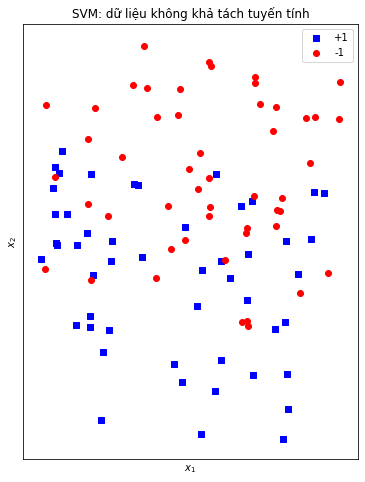

In [2]:
# setting the plot
fig, ax = plt.subplots(figsize=(6,8))
ax.set_title('SVM: dữ liệu không khả tách tuyến tính')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xticks(())
ax.set_yticks(())

# plot the original data
ax.scatter(X_1_data_1, X_1_data_2, label='+1', marker='s', c='b')
ax.scatter(X_2_data_1, X_2_data_2, label='-1', c='r')
ax.legend()
plt.show()

In [3]:
# get transformed data
def getTransformedData(X, Y, N, M):
    X_data = np.empty((0,M))
    t_data = np.array([])
    for i in range(2):
        X_data = np.vstack((X_data, transformClassData(X[i], Y[i], N, M)))
    t_data = np.hstack((t_data, [1 for i in range(N)]))
    t_data = np.hstack((t_data, [-1 for i in range(N)]))
    return X_data, t_data.reshape(2*N,1)

# transform data of one class
def transformClassData(X, Y, N, M):
    res = np.empty((0,M))
    for i in range(N):
        res = np.vstack((res, getTransformedFeature(X[i], Y[i], M)))
    return res

# transform each row of data
def getTransformedFeature(x, y, M):
    res = np.array([])
    count = 0
    exp_1 = 0
    exp_2 = 0
    while(True):
        res = np.append(res, (x**exp_1)*(y**exp_2))
        count += 1
        if (count == M):
            break
        else:
            exp_1 -= 1
            if (exp_1 == -1):
                exp_1 = exp_2 + 1
                exp_2 = 0
            else:
                exp_2 += 1
    return res

# predict function
def predict(X, Y, w, b, M):
    N = len(X[0])
    Z = np.empty((0,N))
    for x,y in zip(X,Y):
        X_ = transformClassData(x, y, N, M-1)
        z = np.dot(X_,w) + b
        z[z > 0] = 1
        z[z < 0] = -1
        Z = np.vstack((Z,z.T))
    return Z

# calculating linear boundary
def getBoundaryY(X, M, w, b, line_index):
    Y = np.array([])
    if (M == 4):
        for x in X:
            y = (line_index - b - np.dot(w[:2].T, np.array([[1],[x]])))/w[2]
            Y = np.append(Y, y)
    return Y

# # calculating linear boundary
# def getBoundaryY(X, Y, M, w, b):
#     Y_0_ = np.array([])
#     Y_1_ = np.array([])
#     Y_2_ = np.array([])
#     for x in X:
#         Y_0_f = np.array([])
#         Y_0_y = np.array([])
#         Y_1_f = np.array([])
#         Y_1_y = np.array([])
#         Y_2_f = np.array([])
#         Y_2_y = np.array([])
#         for y in Y:
#             data = getTransformedFeature(x, y, M-1).reshape(M-1,1)
#             y_ = np.dot(w.T,data) + b
#             if (y_.round(1) == 0):
#                 Y_0_y = np.append(Y_0_y, y)
#                 Y_0_f = np.append(Y_0_f, y_)
#             elif (y_.round(1) == 1):
#                 Y_1_y = np.append(Y_1_y, y)
#                 Y_1_f = np.append(Y_1_f, y_)
#             elif (y_.round(1) == -1):
#                 Y_2_y = np.append(Y_2_y, y)
#                 Y_2_f = np.append(Y_2_f, y_)
#         if (len(Y_0_f) > 0):
#             Y_0_f = np.absolute(Y_0_f)
#             Y_0_ = np.append(Y_0_, Y_0_y[np.where(Y_0_f == np.amin(Y_0_f))[0][0]])
#         if (len(Y_1_f) > 0):
#             Y_1_f = np.absolute(Y_1_f)
#             Y_1_ = np.append(Y_1_, Y_1_y[np.where(Y_1_f == np.amin(Y_1_f))[0][0]])
#         if (len(Y_2_f) > 0):
#             Y_2_f = np.absolute(Y_2_f)        
#             Y_2_ = np.append(Y_2_, Y_2_y[np.where(Y_2_f == np.amin(Y_2_f))[0][0]])
#     return Y_0_, Y_1_, Y_2_

# get points on margin
def getPointOnMargin(X1,Y1,X2,Y2,M,w,b):
    x_margin_1 = np.array([])
    y_margin_1 = np.array([])
    x_margin_2 = np.array([])
    y_margin_2 = np.array([])
    for i in range(len(X1)):
        data_1 = getTransformedFeature(X1[i], Y1[i], M-1).reshape(M-1,1)
        data_2 = getTransformedFeature(X2[i], Y2[i], M-1).reshape(M-1,1)
        y_1 = np.dot(w.T,data_1) + b
        y_2 = np.dot(w.T,data_2) + b
        if (y_1.round(2) == 1):
            x_margin_1 = np.append(x_margin_1, X1[i])
            y_margin_1 = np.append(y_margin_1, Y1[i])
        if (y_2.round(2) == -1):
            x_margin_2 = np.append(x_margin_2, X2[i])
            y_margin_2 = np.append(y_margin_2, Y2[i])
    return x_margin_1,y_margin_1,x_margin_2,y_margin_2

# get points on right margin area
def getPointOnRightMarginArea(X1,Y1,X2,Y2,M,w,b):
    x_right_margin_1 = np.array([])
    y_right_margin_1 = np.array([])
    x_right_margin_2 = np.array([])
    y_right_margin_2 = np.array([])
    for i in range(len(X1)):
        data_1 = getTransformedFeature(X1[i], Y1[i], M-1).reshape(M-1,1)
        data_2 = getTransformedFeature(X2[i], Y2[i], M-1).reshape(M-1,1)
        y_1 = np.dot(w.T,data_1) + b
        y_2 = np.dot(w.T,data_2) + b
        if (0 < y_1 and y_1 < 1):
            x_right_margin_1 = np.append(x_right_margin_1, X1[i])
            y_right_margin_1 = np.append(y_right_margin_1, Y1[i])
        if (-1 < y_2 and y_2 < 0):
            x_right_margin_2 = np.append(x_right_margin_2, X2[i])
            y_right_margin_2 = np.append(y_right_margin_2, Y2[i])
    return x_right_margin_1,y_right_margin_1,x_right_margin_2,y_right_margin_2

# get points on wrong margin area
def getPointOnWrongMarginArea(X1,Y1,X2,Y2,M,w,b):
    x_wrong_margin_1 = np.array([])
    y_wrong_margin_1 = np.array([])
    x_wrong_margin_2 = np.array([])
    y_wrong_margin_2 = np.array([])
    for i in range(len(X1)):
        data_1 = getTransformedFeature(X1[i], Y1[i], M-1).reshape(M-1,1)
        data_2 = getTransformedFeature(X2[i], Y2[i], M-1).reshape(M-1,1)
        y_1 = np.dot(w.T,data_1) + b
        y_2 = np.dot(w.T,data_2) + b
        if (y_1 < 0):
            x_wrong_margin_1 = np.append(x_wrong_margin_1, X1[i])
            y_wrong_margin_1 = np.append(y_wrong_margin_1, Y1[i])
        if (y_2 > 0):
            x_wrong_margin_2 = np.append(x_wrong_margin_2, X2[i])
            y_wrong_margin_2 = np.append(y_wrong_margin_2, Y2[i])
    return x_wrong_margin_1,y_wrong_margin_1,x_wrong_margin_2,y_wrong_margin_2

In [4]:
# feature size
M = 4

# get transformed data
X_ = np.vstack((X_1_data_1,X_2_data_1))
Y_ = np.vstack((X_1_data_2,X_2_data_2))
(X_data, t_data) = getTransformedData(X_, Y_, N, M-1)

# Primal Problem

In [5]:
def solve(C, ax):
    # CVXOPT variables
     # K
    K = np.zeros((M + 2*N, M + 2*N))
    K[:M-1,:M-1] = np.identity(M-1)
    K = matrix(K)
     # p
    p = np.zeros((M + 2*N,1))
    p[M:] = C
    p = matrix(p)
     # G
    G = np.zeros((4*N, M + 2*N))
    G[:2*N,:M-1] = -np.copy(t_data)*np.copy(X_data)
    G[:2*N,M-1:M] = -np.copy(t_data)
    G[:2*N,M:] = -np.identity(2*N)
    G[2*N:,M:] = -np.identity(2*N)
    G = matrix(G)
     # h
    h = np.zeros((4*N,1))
    h[:2*N] = -1
    h = matrix(h)

    # solve
    solvers.options['show_progress'] = False
    solution = solvers.qp(K,p,G,h)

    # get solution
    w_b_xi = np.array(solution['x'])
    w = w_b_xi[:M-1]
    b = w_b_xi[M-1][0]
    xi = w_b_xi[M:]
    xi[xi.round(2) == 0] = 0
    
    wrong_class_count = len(xi[xi >= 1])
    sum_xi = np.sum(xi)

    # print('w: \n', w)
    # print('b: \n', b)
    # print('ξ: \n', xi)

    # plot data
    x = np.arange(1.5,3.25,0.01)
    y = np.arange(-3.5,8.5,0.01)
    (xx, yy) = np.meshgrid(x, y)
    z = predict(xx,yy,w,b,M)

    # decision boundary
    # (y_0,y_1,y_2) = getBoundaryY(x, y, M, w, b)
    y_0 = getBoundaryY(x, M, w, b, 0)
    y_1 = getBoundaryY(x, M, w, b, 1)
    y_2 = getBoundaryY(x, M, w, b, -1)

    # get points on margin
    (x_margin_1,y_margin_1,x_margin_2,y_margin_2) = getPointOnMargin(X_1_data_1,X_1_data_2,X_2_data_1,X_2_data_2,M,w,b)

    # get points on right margin area
    (x_right_margin_1,y_right_margin_1,x_right_margin_2,y_right_margin_2) = getPointOnRightMarginArea(X_1_data_1,X_1_data_2,X_2_data_1,X_2_data_2,M,w,b)

    # get points on wrong margin area
    (x_wrong_margin_1,y_wrong_margin_1,x_wrong_margin_2,y_wrong_margin_2) = getPointOnWrongMarginArea(X_1_data_1,X_1_data_2,X_2_data_1,X_2_data_2,M,w,b)

    # get angle
    angle = np.rad2deg(np.arctan2(y_0[15]-y_0[5], x[15]-x[5]))

    # setting the plot
    ax.set_title(r'$\bf{C}$ = %s , $\bf{Wrong Class Count}$ = %s , $\bf{\sum_n^N \xi_{n}}$ = %s' % (C,wrong_class_count,sum_xi))
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xticks(())
    ax.set_yticks(())

    # plot the original data
    ax.contourf(x,y,z,colors=['r','b'], alpha=0.3)
    ax.scatter(X_1_data_1, X_1_data_2, label='+1', marker='s', c='b')
    ax.scatter(X_2_data_1, X_2_data_2, label='-1', c='r')
    ax.scatter(x_margin_1, y_margin_1, s=150, facecolors='none', edgecolors='b')
    ax.scatter(x_margin_2, y_margin_2, s=150, facecolors='none', edgecolors='r')
    ax.scatter(x_right_margin_1, y_right_margin_1, s=150, facecolors='none', edgecolors='b')
    ax.scatter(x_right_margin_2, y_right_margin_2, s=150, facecolors='none', edgecolors='r')
    ax.scatter(x_wrong_margin_1, y_wrong_margin_1, s=150, facecolors='none', edgecolors='r')
    ax.scatter(x_wrong_margin_2, y_wrong_margin_2, s=150, facecolors='none', edgecolors='b')
    rotation_angle = ax.transData.transform_angles(np.array((angle,)), np.array([x[5], y_0[5]]).reshape((1, 2)))[0]
    ax.plot(x,y_0,c='black')
    ax.text(x[5],y_0[5]+0.05,r'$\bf w^{T}x$$+b=0$',rotation_mode='anchor', rotation=rotation_angle)
    ax.plot(x,y_1,c='b',ls='--')
    ax.text(x[5],y_1[5]+0.05,r'$\bf w^{T}x$$+b=1$',rotation_mode='anchor', rotation=rotation_angle)
    ax.plot(x,y_2,c='r',ls='--')
    ax.text(x[5],y_2[5]+0.05,r'$\bf w^{T}x$$+b=-1$',rotation_mode='anchor', rotation=rotation_angle)
    ax.legend()

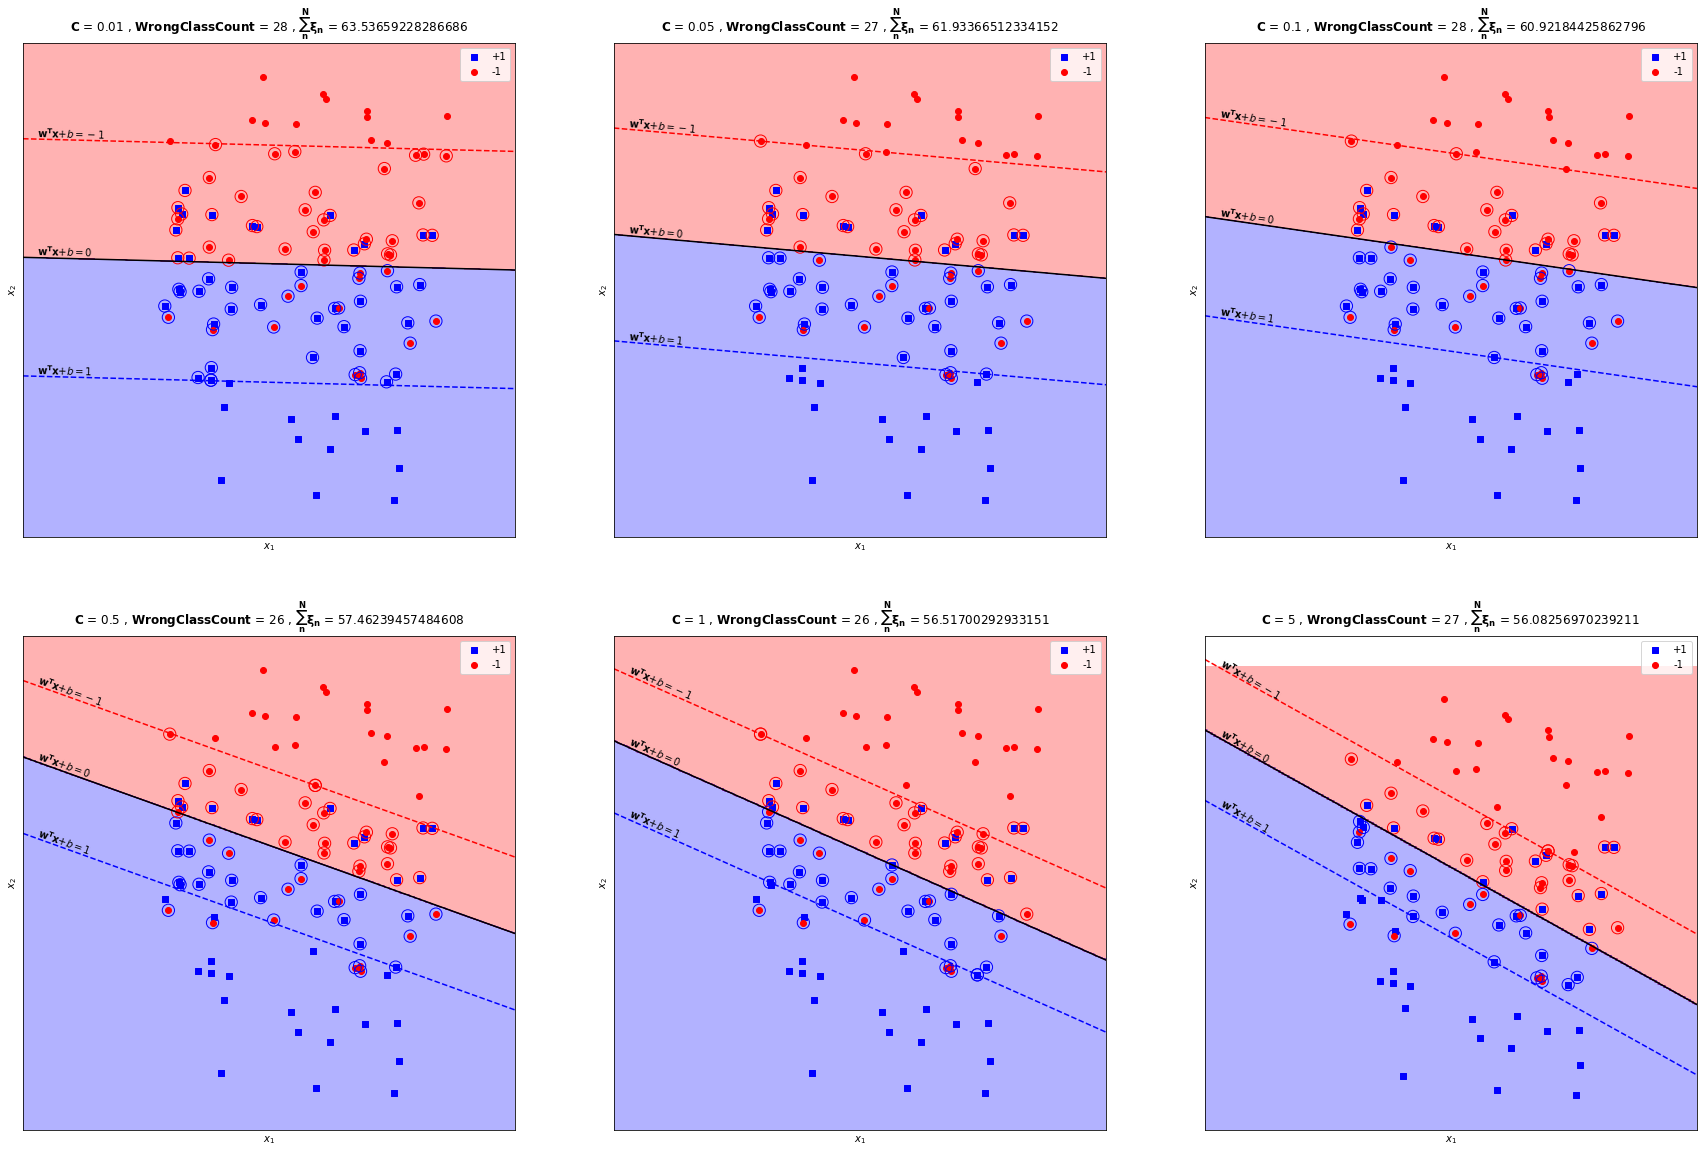

In [6]:
# setting plots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(30,20))

# solving primal problem
solve(C=0.01,ax=ax1)
solve(C=0.05,ax=ax2)
solve(C=0.1,ax=ax3)
solve(C=0.5,ax=ax4)
solve(C=1,ax=ax5)
solve(C=5,ax=ax6)